# Comparação de Modelos

Para essa tarefa, temos um conjunto de consultas que foram realizadas em diferentes modelos e avaliadas com a ajuda de um *LLM*. Vamos carregá-las e usá-las para calcular as pontuações dos resultados de pesquisa dos modelos.

## Imports

Primeiro, vamos importar as bibliotecas necessárias. Estas são:

- `numpy` para manuseio de *arrays*;
- `os` para manuseio de diretórios;
- `pandas` para utilizar *DataFrames*;
- `plotly.express` para criação de gráficos interativos;
- `re` para operações *RegEx*.

In [1]:
# Bibliotecas
import numpy as np
import os
import pandas as pd
import plotly.express as px
import re

## Carregando resultados avaliados

Todos os pares de consulta e resultado retornados pelos modelos são avaliados de 0 a 5 em termos de relevância de acordo com a consulta. Temos um banco de pares já avaliados, salvos no arquivo `review_bank.xlsx`. Estes resultados foram avaliados em três modelos diferentes - *BM25*, *TF-IDF* e *e5* pelos integrantes de nosso grupo. Por fim, foi calculado uma média e eles foram arredondados para se encaixarem no padrão de 0 a 5.

Vamos tentar coletar suas informações em um *DataFrame*:

In [2]:
# Tenta ler o arquivo review_bank.xlsx e transformar num DataFrame
try:
    review_bank = pd.read_excel('reviews/review_bank.xlsx')
# Caso não funcione, cria um Dataframe vazio
except:
    review_bank = pd.DataFrame()

Os resultados de uma consulta feita a um modelo que ainda não estão no banco são adicionados ao arquivo `missing_reviews_bank.xlsx`. Dentre esses, estão aqueles ainda não avaliados e os que foram avaliados por um *LLM*. No nosso caso, tivemos avaliações feitas pelo *GPT* e pelo *LLamMa3*.

Vamos tentar salvar essas informações em um *DataFrame* e, caso possível, vamos coletar as entradas já avaliadas e adicioná-las ao banco de dados `review_bank`, para que ele englobe todas as respostas.

In [3]:
# Tenta ler o arquivo missing_reviews_bank.xlsx e transformar num DataFrame
try:
    missing_reviews_bank = pd.read_excel("reviews/missing_reviews_bank.xlsx")
    # Salva as entradas com Nota em outra tabela
    extra_reviews = missing_reviews_bank[missing_reviews_bank["Nota"] != None]
    # Adapta e filtra as colunas
    extra_reviews.rename(columns={"title": "Receita"}, inplace=True)
    extra_reviews[["Tipo", "Descrição", "Query", "Receita", "Evaluator", "Nota"]]
    # Atualiza a tabela com as entradas já avaliadas
    review_bank = pd.concat([review_bank, extra_reviews])
# Caso não seja possível, cria um DataFrame vazio
except:
    missing_reviews_bank = pd.DataFrame()

Para coletar a nota do resultado de uma receita para uma *query* específica, vamos criar uma função chamada `lookup_rating`, que leva como parâmetros a *query* e a receita. Vamos tentar filtrar o DataFrame `review_bank`, já com todas as receitas avaliadas, para que retorne apenas as entradas que atendam ao par de *query*/receita. 

As colunas relevantes serão a nota e o avaliador, que pode ser uma pessoa ou um *LLM*. Dessa forma, retornamos a nota, com preferência sendo dada às respostas fornecidas por pessoas, uma vez que temos maior controle de sua qualidade.

In [4]:
# Função para retornar a nota de uma receita dada uma query
def lookup_rating(query, recipe):
    # Tenta coletar a nota da receita
    try:
        # Filtra o DataFrame com todas as receitas avaliadas para bater com o par de query/receita
        ratings = review_bank[(review_bank['Query'] == query) & (review_bank['Receita'] == recipe)][["Nota", "Evaluator"]]
        # Tenta coletar a linha onde o avaliador é uma pessoa
        person_rating = ratings[ratings['Evaluator'] == "Person"]
        # Caso esta linha não esteja vazia, retorna a nota dada por pessoas
        if not person_rating.empty:
            return person_rating.values[0][0]
        # Caso contrário, retorna a primeira nota dada por LLMs.
        else:
            nota = ratings.iloc[0].values[0]
            return nota
    # Caso não funcione, retorna None.
    except:
        return None

## Resultados dos modelos

Cada modelo deve gerar o resultado de sua avaliação na pasta `/output`, no formato `.xlsx` e com o nome seguindo o padrão `Results_[Model_name].xlsx`. Vamos criar uma lista com esses arquivos:

In [5]:
# Padrão a ser encontrado nos arquivos
pattern = r"Results_.*\.xlsx$"
# Busca os arquivos na pasta de output por matching de RegEx
model_results_paths = [os.path.join('output', file) for file in os.listdir('output') if re.match(pattern, file)]

Nestas planilhas, cada modelo retornará as 5 melhores receitas para cada *query* de nosso banco de *queries* presente em `input/Recipe_Search_Questions.xlsx`. As *queries* são divididas em duas categorias, *Keywords* e *Semantic*. A primeira apresenta apenas as palavras-chaves do que se procura, sendo direto ao ponto. As perguntas consideradas "Simples" são deste tipo. Enquanto isso, perguntas do tipo *Semantic* possuem informações onde o contexto deve ser considerado para retornar algo realmente relevante, como a noção de exclusão de algum item específico. Perguntas deste tipo possuem dificuldade "Média", "Díficil" ou "Difícil+" (denominadas também de Complexas).

Vamos criar um dicionário, onde o nome do modelo será a chave e seus resultados serão a chave. Temos atualmente quatro modelos, sendo estes o *TF-IDF*, *BM25*, um modelo semântico utilizando *e5* e um modelo híbrido que combina os últimos dois.

In [6]:
# Dicionário para salvar os resultados dos modelos
models = {}
# Percorre os caminhos relevantes da lista
for model_result_path in model_results_paths:
    # Coleta o nome do modelo pelo arquivo
    model_name = re.search(r"Results_(.*).xlsx", os.path.basename(model_result_path)).group(1)
    # Cria um DataFrame com os resultados
    result_df = pd.read_excel(model_result_path)
    # Cria uma coluna de nota utilizando a função lookup_rating
    result_df["Nota"] = result_df.apply(lambda row: lookup_rating(row['Query'], row['title']), axis=1)
    # Cria o par chave/valor para o dicionário
    models[model_name] = result_df

# Avaliação dos modelos

Para fins de comparação de cada modelo, vamos calcular a média das notas para cada grupo de perguntas. Isso envolve a separação por diferentes valores na coluna Descrição (dificuldade da pergunta) e por diferentes valores na coluna Tipo (semântica ou palavra-chave).

In [7]:
# Cria um DataFrame para resultados sem nota
missing_reviews = pd.DataFrame()
# Cria dicionários para armazenar as médias, baseada na dificuldade da pergunta
simple_mean = {}
media_mean = {}
hard_mean = {}
complex_mean = {}
# Cria dicionários para armazenar as médias, baseada no tipo de pergunta
semantic_mean = {}
keyword_mean = {}
# Cria dicionário para a média geral
mean = {}
# Percorre os modelos do dicionário
for model in models:
    # Cria um DataFrame para os resultados
    df = models[model]
    # Coleta as linhas sem nota do DataFrame
    model_missing_reviews = df[df['Nota'].isnull()]
    # Cria DataFrames filtrados para cada dificuldade
    simple_question = df[df['Descrição'] == 'Pergunta simples']
    media_question = df[df['Descrição'] == 'Pergunta média']
    hard_question = df[df['Descrição'] == 'Pergunta difícil']
    complex_question = df[df['Descrição'] == 'Pergunta difícil +']
    # Cria DataFrames filtrados para cada tipo de pergunta
    keyword = df[df['Tipo'] == 'Keywords']
    semantic = df[df['Tipo'] == 'Semantica']
    # Adiciona as notas médias nos dicionários de dificuldade
    simple_mean[model] = simple_question['Nota'].mean()
    media_mean[model] = media_question['Nota'].mean()
    hard_mean[model] = hard_question['Nota'].mean()
    complex_mean[model] = complex_question['Nota'].mean()
    # Nota média do modelo
    model_mean = df['Nota'].mean()
    mean[model] = model_mean
    # Adiciona as notas médias nos dicionários de tipo de pegrgunta
    keyword_mean[model] = keyword['Nota'].mean()
    semantic_mean[model] = semantic['Nota'].mean()
    # Printa as informações de avaliações ausentes de cada modelo
    print(f'Modelo: {model}')
    print(f'Média de pontuação: {model_mean}')
    print(f'Avaliações ausentes: {len(model_missing_reviews)}')
    # Adiciona as linhas sem avaliação ao DataFrame
    missing_reviews = pd.concat([missing_reviews, model_missing_reviews])

Modelo: Bm25
Média de pontuação: 1.9209302325581394
Avaliações ausentes: 0
Modelo: hybrid
Média de pontuação: 3.3302325581395347
Avaliações ausentes: 0
Modelo: semantic
Média de pontuação: 3.3302325581395347
Avaliações ausentes: 0
Modelo: Tfidf
Média de pontuação: 2.572093023255814
Avaliações ausentes: 0


Também calcularemos o *DCG (Discounted Cumulative Gain)* para utilizarmos como métrica de desempenho. Esta é a fórmula que será utilizada:

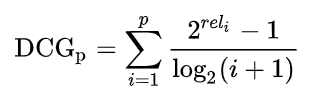

Vamos criar uma função para calculá-la:

In [8]:
# Função para calcular o DCG
def calculate_dcg(scores):
    # Versão alternativa: menos foco em relevantes:
    # return sum(score / np.log2(idx + 2) for idx, score in enumerate(scores))
    return sum((2**score - 1) / np.log2(idx + 2) for idx, score in enumerate(scores))

Podemos assim calcular o *DCG* para cada *query* de um modelo. Para calcular a nota *DCG* final de um modelo, basta realizar a média do valor obtido em cada *query*. Vamos criar uma função auxiliar para isto:

In [9]:
# Função para retornar o DCG de um modelo
def final_dcg(df):
    # Agrupa o DataFrame por queries
    grouped = df.groupby('Query')
    # Calcula a nota DCG para todas as queries
    dcg_scores = grouped['Nota'].apply(calculate_dcg)
    # Calcula a média das queries
    mean_dcg = dcg_scores.mean()
    return mean_dcg

Vamos calcular a maior nota que poderíamos obter:

In [10]:
# Define o número de resultados e pontuação máxima
p = 5
max_score = 5
# Calcula a nota
max_dcg = sum((2**max_score - 1) / np.log2(i + 2) for i in range(p))
print(f"Valor de DCG máximo para {p} resultados com uma pontuação de {max_score}: {max_dcg}")

Valor de DCG máximo para 5 resultados com uma pontuação de 5: 91.40223268526115


Agora, vamos realizar o processo análogo para o cálculo do *DCG* consolidado, por dificuldade e por tipo de pergunta:

In [11]:
# Cria dicionários para armazenar os resultados DCG, baseada na dificuldade da pergunta
simple_dcg = {}
media_dcg = {}
hard_dcg = {}
complex_dcg = {}
# Cria dicionários para armazenar os resultados DCG, baseada no tipo de pergunta
semantic_dcg = {}
keyword_dcg = {}
# Cria dicionário para a nota de DCG geral
dcg = {}
# Percorre os modelos do dicionário
for model in models:
    # Cria um DataFrame para os resultados
    df = models[model]
    # Cria DataFrames filtrados para cada dificuldade
    simple_question = df[df['Descrição'] == 'Pergunta simples']
    media_question = df[df['Descrição'] == 'Pergunta média']
    hard_question = df[df['Descrição'] == 'Pergunta difícil']
    complex_question = df[df['Descrição'] == 'Pergunta difícil +']
    # Cria DataFrames filtrados para cada tipo de pergunta
    keyword = df[df['Tipo'] == 'Keywords']
    semantic = df[df['Tipo'] == 'Semantica']
    # Adiciona as notas de DCG nos dicionários de dificuldade
    simple_dcg[model] = final_dcg(simple_question)
    media_dcg[model] = final_dcg(media_question)
    hard_dcg[model] = final_dcg(hard_question)
    complex_dcg[model] = final_dcg(complex_question)
    # DCG do modelo
    dcg[model] = final_dcg(df)
    # Adiciona as notas de DCG nos dicionários de tipo de pegrgunta
    keyword_dcg[model] = final_dcg(keyword)
    semantic_dcg[model] = final_dcg(semantic)
    # Printa as informações de avaliações ausentes de cada modelo
    print(f'Modelo: {model}')
    print(f'Pontuação DCG: {dcg[model]}')

Modelo: Bm25
Pontuação DCG: 16.11471717251813
Modelo: hybrid
Pontuação DCG: 41.62220364689449
Modelo: semantic
Pontuação DCG: 41.62220364689449
Modelo: Tfidf
Pontuação DCG: 30.213202107997986


## Visualização dos resultados

### Média

Primeiro, vamos retornar uma média geral de cada um dos modelos:

In [12]:
# Separa as chaves (modelos) e valores (notas)
modelos = list(mean.keys())
notas = list(mean.values())
# Cria um DataFrame auxiliar
df = pd.DataFrame(list(zip(modelos, notas)), columns=['Modelo', 'Nota'])
# Ordena por nota
df = df.sort_values('Nota')
# Cria um gráfico de barras, com limites em 0 e 5, com cores contínuas
fig = px.bar(df, x='Modelo', y='Nota', color='Nota', color_continuous_scale='Viridis',
             hover_data={'Nota':':.2f'}, range_color=[0,5])
# Atualiza a estética do gráfico
fig.update_layout(
    title='Notas Médias dos Modelos',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Adapta as informações do Hover
fig.update_traces(hovertemplate='Modelo: %{x}<br>Média: %{y:.2f}')
# Limita o gráfico entre 0 e 5
fig.update_yaxes(range=[0, 5])
# Mostra o gráfico
fig.show()

Agora, vamos quebrar essas barras consolidadas para termos uma barra estacada, onde cada *stack* corresponde a uma dificuldade de pergunta.

In [13]:
# Coleta o nome dos modelos
dif_means = {model: {} for model in mean.keys()}
# Preenche a informação para cada nível de dificuldade
for model in dif_means:
    dif_means[model]["simple"] = simple_mean[model]
    dif_means[model]["media"] = media_mean[model]
    dif_means[model]["hard"] = hard_mean[model]
    dif_means[model]["complex"] = complex_mean[model]
# Cria DataFrame auxiliar
df = pd.DataFrame.from_dict(dif_means, orient='index')
# Cria coluna Total que consolida os valores
df['Total'] = df.sum(axis=1)
# Ordena de acordo com o total
df = df.sort_values('Total', ascending=True)
# Remove a coluna
df = df.drop(columns=['Total'])
# Cria paleta de cores
color_palette = px.colors.qualitative.Pastel
# Cria gráfico de barras estacado de acordo com dificuldade
fig = px.bar(df, barmode='stack', color_discrete_sequence=color_palette, labels={'index':'Modelo', 'value':'Média', 'variable':'Dificuldade'})
# Atualiza a estética do gráfico
fig.update_layout(
    title='Notas Médias dos Modelos - Divisão por Dificuldade',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Mostra o gráfico
fig.show()

Por fim, vamos realizar o processo análogo para os tipos de pergunta:

In [14]:
# Coleta o nome dos modelos
type_means = {model: {} for model in mean.keys()}
# Preenche as informações para cada tipo de pergunta
for model in type_means:
    type_means[model]["semantic"] = semantic_mean[model]
    type_means[model]["keyword"] = keyword_mean[model]
# Cria DataFrame auxiliar
df = pd.DataFrame.from_dict(type_means, orient='index')
# Cria coluna Total que consolida os valores
df['Total'] = df.sum(axis=1)
# Ordena de acordo com o total
df = df.sort_values('Total', ascending=True)
# Remove a coluna
df = df.drop(columns=['Total'])
# Cria paleta de cores
color_palette = px.colors.qualitative.Pastel
# Cria gráfico de barras estacado de acordo com tipo de pergunta
fig = px.bar(df, barmode='stack', color_discrete_sequence=color_palette, labels={'index':'Modelo', 'value':'Média', 'variable':'Tipo de Pergunta'})
# Atualiza a estética do gráfico
fig.update_layout(
    title='Notas Médias dos Modelos - Divisão por Tipo de Pergunta',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Mostra o gráfico
fig.show()

### DCG

Vamos realizar o processo análogo para o *DCG*. Primeiro, um gráfico com a nota *DCG* consolidada para cada modelo:

In [15]:
# Separa as chaves (modelos) e valores (notas)
modelos = list(dcg.keys())
notas = list(dcg.values())
# Cria um DataFrame auxiliar
df = pd.DataFrame(list(zip(modelos, notas)), columns=['Modelo', 'Nota'])
# Ordena por nota
df = df.sort_values('Nota')
# Cria um gráfico de barras, com cores contínuas no range [0, 91.40] (DCG) máximo
fig = px.bar(df, x='Modelo', y='Nota', color='Nota', color_continuous_scale='Viridis',
             hover_data={'Nota':':.2f'}, range_color=[0,91.40])
# Atualiza a estética do gráfico
fig.update_layout(
    title='Pontuação DCG dos Modelos',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Adapta as informações do Hover
fig.update_traces(hovertemplate='Modelo: %{x}<br>DCG: %{y:.2f}')
# Mostra o gráfico
fig.show()

Agora, vamos fazer por dificuldade de pergunta:

In [16]:
# Coleta o nome dos modelos
dif_dcg = {model: {} for model in dcg.keys()}
# Preenche a informação para cada nível de dificuldade
for model in dif_dcg:
    dif_dcg[model]["simple"] = simple_dcg[model]
    dif_dcg[model]["media"] = media_dcg[model]
    dif_dcg[model]["hard"] = hard_dcg[model]
    dif_dcg[model]["complex"] = complex_dcg[model]
# Cria DataFrame auxiliar
df = pd.DataFrame.from_dict(dif_dcg, orient='index')
# Cria coluna Total que consolida os valores
df['Total'] = df.sum(axis=1)
# Ordena de acordo com o total
df = df.sort_values('Total', ascending=True)
# Remove a coluna
df = df.drop(columns=['Total'])
# Cria paleta de cores
color_palette = px.colors.qualitative.Pastel
# Cria gráfico de barras estacado de acordo com dificuldade
fig = px.bar(df, barmode='stack', color_discrete_sequence=color_palette, labels={'index':'Modelo', 'value':'DCG', 'variable':'Tipo'})
# Atualiza a estética do gráfico
fig.update_layout(
    title='Pontuação DCG dos Modelos - Divisão por Dificuldade',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Mostra o gráfico
fig.show()

Por fim, a divisão por tipo de pergunta:

In [17]:
# Coleta o nome dos modelos
type_dcg = {model: {} for model in dcg.keys()}
# Preenche as informações para cada tipo de pergunta
for model in type_dcg:
    type_dcg[model]["semantic"] = semantic_dcg[model]
    type_dcg[model]["keyword"] = keyword_dcg[model]
# Cria DataFrame auxiliar
df = pd.DataFrame.from_dict(type_dcg, orient='index')
# Cria coluna Total que consolida os valores
df['Total'] = df.sum(axis=1)
# Ordena de acordo com o total
df = df.sort_values('Total', ascending=True)
# Remove a coluna
df = df.drop(columns=['Total'])
# Cria paleta de cores
color_palette = px.colors.qualitative.Pastel
# Cria gráfico de barras estacado de acordo com tipo de pergunta
fig = px.bar(df, barmode='stack', color_discrete_sequence=color_palette, labels={'index':'Modelo', 'value':'DCG', 'variable':'Tipo de Pergunta'})
# Atualiza a estética do gráfico
fig.update_layout(
    title='Pontuação DCG dos Modelos - Divisão por Tipo de Pergunta',
    title_font=dict(size=24, family='Courier', color='black'),
    showlegend=True,
    template='plotly_white'
)
# Mostra o gráfico
fig.show()

### Tabelas de conclusão

Por fim, vamos criar uma tabela com os resultados de média:

In [18]:
# Converte os resultados para DataFrames
df_simple = pd.DataFrame(list(simple_mean.items()), columns=['Model', 'SimpleMean'])
df_media = pd.DataFrame(list(media_mean.items()), columns=['Model', 'MediaMean'])
df_hard = pd.DataFrame(list(hard_mean.items()), columns=['Model', 'HardMean'])
df_complex = pd.DataFrame(list(complex_mean.items()), columns=['Model', 'ComplexMean'])
df_semantic = pd.DataFrame(list(semantic_mean.items()), columns=['Model', 'SemanticMean'])
df_keyword = pd.DataFrame(list(keyword_mean.items()), columns=['Model', 'KeywordMean'])
# Concatena os DataFrames
final_mean = pd.concat([df_simple, df_media['MediaMean'], df_hard['HardMean'], df_complex['ComplexMean'], df_semantic['SemanticMean'], df_keyword['KeywordMean']], axis=1)
# Ordem das linhas
model_order = ['Bm25', 'Tfidf', 'hybrid', 'semantic']
# Reindexa o DataFrame para a ordem correta
final_mean = final_mean.set_index('Model').loc[model_order].reset_index()
# Printa o DataFrame
final_mean

,Model,SimpleMean,MediaMean,HardMean,ComplexMean,SemanticMean,KeywordMean
0,Bm25,2.388235,1.766667,1.775,1.100000,1.615385,2.388235
1,Tfidf,3.305882,1.916667,2.925,1.333333,2.092308,3.305882
2,hybrid,3.917647,2.583333,3.450,3.000000,2.946154,3.917647
3,semantic,3.917647,2.583333,3.450,3.000000,2.946154,3.917647


Realizando o processo anáogo para *DCG*:

In [19]:
# Converte os resultados para DataFrames
df_simple = pd.DataFrame(list(simple_dcg.items()), columns=['Model', 'SimpleDCG'])
df_media = pd.DataFrame(list(media_dcg.items()), columns=['Model', 'MediaDCG'])
df_hard = pd.DataFrame(list(hard_dcg.items()), columns=['Model', 'HardDCG'])
df_complex = pd.DataFrame(list(complex_dcg.items()), columns=['Model', 'ComplexDCG'])
df_semantic = pd.DataFrame(list(semantic_dcg.items()), columns=['Model', 'SemanticDCG'])
df_keyword = pd.DataFrame(list(keyword_dcg.items()), columns=['Model', 'KeywordDCG'])
# Concatena os DataFrames
final_dcgs = pd.concat([df_simple, df_media['MediaDCG'], df_hard['HardDCG'], df_complex['ComplexDCG'], df_semantic['SemanticDCG'], df_keyword['KeywordDCG']], axis=1)
# Ordem das linhas
model_order = ['Bm25', 'Tfidf', 'hybrid', 'semantic']
# Reindexa o DataFrame para a ordem correta
final_dcgs = final_dcgs.set_index('Model').loc[model_order].reset_index()
# Printa o DataFrame
final_dcgs

,Model,SimpleDCG,MediaDCG,HardDCG,ComplexDCG,SemanticDCG,KeywordDCG
0,Bm25,23.923489,13.254972,11.188748,6.277314,11.008982,23.923489
1,Tfidf,39.075916,21.156781,36.670962,14.604673,24.418350,39.075916
2,hybrid,50.335440,28.473178,43.256322,41.053928,35.925087,50.335440
3,semantic,50.335440,28.473178,43.256322,41.053928,35.925087,50.335440


# Avaliando os resultados faltantes

Nessa parte, vamos pegar os resultados sem nota observados durante a coleta de médias e avaliá-los com uma *LLM*. Estas são os resultados faltantes:

In [20]:
missing_reviews

,Tipo,Descrição,Query,id,title,body,Nota


Vamos criar uma função que cria o *prompt* para que o *GPT* avalie:

In [21]:
# Função para gerar a prompt do GPT
def get_gpt_template(resulting_recipe, query):
    return f"""
        You are a query result validator assistant tasked with evaluating the quality of a given recipe in answering a given query.

        Here is the recipe: \

        {resulting_recipe}

        Here is the query:\

        {query}

        Now evaluate from 0 to 5, the relevance of the recipe for answering the given query, where 0 is unrelated, 1 is poorly related, 2 is a little relevant but miss some important things, 3 is relevant but miss some restrictions, 4 is a relevant recipe that nearly matches all the possible criterias, and 5 is a perfect result, where every possible consideration and restrain included in the query is answered in the recipe. Include both your grading and a brief justificative of the grade.


        Assistant grading:
        Justificative:
    """

Vamos atualizar a planilha `missing_reviews_bank.xlsx` com essas informações faltantes. Teremos uma coluna com o *prompt* e inicializaremos os valores de nota e avaliador como vazios.

In [22]:
# Adiciona coluna de prompt
missing_reviews["gpt_template"] = missing_reviews.apply(lambda row: get_gpt_template(row['body'], row['Query']), axis=1)
# Coloca valores iniciais para nota e avaliador
missing_reviews["Nota"] = None
missing_reviews["Evaluator"] = " "
# Atualiza a tabela de resultados faltantes
missing_reviews_bank = pd.concat([missing_reviews_bank, missing_reviews])
# Dropa as duplicatas
missing_reviews_bank.drop_duplicates(inplace=True)
# Atualiza o arquivo missing_reviews_bank.xlsx
missing_reviews_bank.to_excel('reviews/missing_reviews_bank.xlsx', index=False)

Caso não tenham resultados faltantes, o código para por aqui. Caso contrário, importamos a função `fill_in_missing_reviews`. Ela utiliza da *API* do *Ollama*, que caso configurado e rodando, utilizará um *LLM* a escolha para tentar avaliá-los.

In [23]:
# Verifica se não há resultados faltantes
if missing_reviews.empty:
    print("Todos os resultados foram avaliados!")
# Caso tenha
else:
    print(f"{len(missing_reviews)} resultados estão faltantes.")
    # Importa a função de fill_in_missing_reviews.py
    from fill_in_missing_reviews import fill_in_missing_reviews
    # Chama a função para avaliar os resultados faltantes
    fill_in_missing_reviews()

Todos os resultados foram avaliados!
